In [ ]:
# makes footprints for 19-port PL

In [89]:
import glob as glob
import os
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from scipy.sparse.linalg import lsmr

%matplotlib inline
#%matplotlib qt

In [42]:
stem = '/Users/bandari/Documents/git.repos/photonics_spectroscopy/notebooks_for_development/data/19pl/'

In [43]:
# read in a test frame 

dark_apapane = stem + 'raw/apapanedark.fits'
test_array = fits.open(dark_apapane)[0].data

In [66]:
# read in a broadband frame

raw_bb_frame_19pl = stem + 'dark_subted/19PL_bb_irnd1.0_optnd3.0.fits'
bb_array = fits.open(raw_bb_frame_19pl)[0].data

In [85]:
# ersatz variance frame

hdul = fits.open('./data/stacked.fits')
test_data = hdul[0].data[0,:,:] # all 3 spectra
array_variance = hdul[0].data[1,:,:]

In [67]:
plt.imshow(bb_array)
plt.show()

In [44]:
# relative positions of all the outputs 
# (can move around with a common offset in (x,y))

rel_pos = {'1':(193,115),
           '2':(202,113),
           '3':(210,111),
           '4':(187,108),
           '5':(196,106),
           '6':(204,105),
           '7':(213,103),
           '8':(181,101),
           '9':(190,100),
           '10':(198,98),
           '11':(207,96),
           '12':(215,94),
           '13':(184,93),
           '14':(192,91),
           '15':(201,90),
           '16':(209,88),
           '17':(186,84),
           '18':(195,83),
           '19':(203,81)}

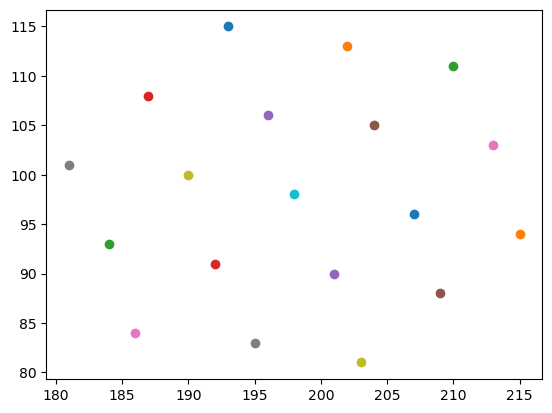

In [45]:
for key in rel_pos.values():
    plt.scatter(key[0],key[1])
plt.show()

In [46]:
# gaussian profile (kind of confusing: coordinates are (lambda, x), instead of (x,y) )
def gaus1d(x_left, len_spec, x_pass, lambda_pass, mu_pass, sigma_pass=1):
    '''
    x_left: x coord of leftmost pixel of spectrum (y coord is assumed to be mu_pass)
    len_spec: length of spectrum [pix]
    x_pass: grid of y-coords in coord system of input
    lambda_pass: grid of x-coords in coord system of input
    mu_pass: profile center (in x_pass coords)
    sigma_pass: profile width (in x_pass coords)
    '''
    
    # condition for lambda axis to be inside footprint
    lambda_cond = np.logical_and(lambda_pass >= x_left, lambda_pass < x_left+len_spec)
    
    #plt.imshow(lambda_cond)
    #plt.show()
    
    # profile spanning entire array
    profile = (1./(sigma_pass*np.sqrt(2.*np.pi))) * np.exp(-0.5 * np.power((x_pass-mu_pass)/sigma_pass,2.) )
    
    # mask regions where there is zero signal
    profile *= lambda_cond
    
    # normalize columns of nonzero signal
    profile = np.divide(profile, np.nanmax(profile))
    
    # restore regions of zero signal as zeros (instead of False)
    profile[~lambda_cond] = 0.
    
    return profile

In [53]:
# wrapper make the enclosing profile of a spectrum

def simple_profile(array_shape, x_left, y_left, len_spec, sigma_pass=1):
    # make simple 1D Gaussian profile in x-direction
    '''
    shape_array: shape of array
    x_left: x-coord of leftmost point of spectrum
    y_left: y-coord of leftmost point of spectrum
    len_spec: length of spectrum (in x-dir)
    sigma_pass: sigma width of profile
    '''
    #(x_left, len_spec, x_pass, mu_pass, sigma_pass)
    array_profile = np.zeros(array_shape)

    xgrid, ygrid = np.meshgrid(np.arange(0,np.shape(array_profile)[1]),np.arange(0,np.shape(array_profile)[0]))
    array_profile = gaus1d(x_left=x_left, len_spec=len_spec, x_pass=ygrid, lambda_pass=xgrid, mu_pass=y_left, sigma_pass=1)

    #plt.imshow(array_profile)
    #plt.show()
    
    # normalize it such that the marginalization in x (in (x,lambda) space) is 1
    # (with a perfect Gaussian profile in x this is redundant)
    
    test2 = array_profile[:,x_left:x_left+len_spec]
    
    array_profile[:,x_left:x_left+len_spec] = np.divide(array_profile[:,x_left:x_left+len_spec],np.sum(array_profile[:,x_left:x_left+len_spec], axis=0))
    
    return array_profile

In [48]:
test = simple_profile(array_shape=np.shape(test_array), x_left=50, y_left=100, len_spec=150, sigma_pass=1)

(256, 320)


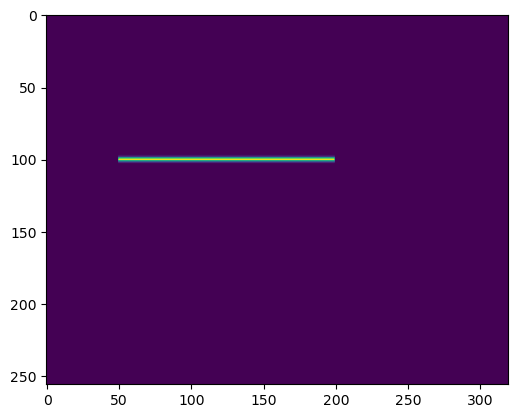

In [49]:
plt.imshow(test)
plt.show()

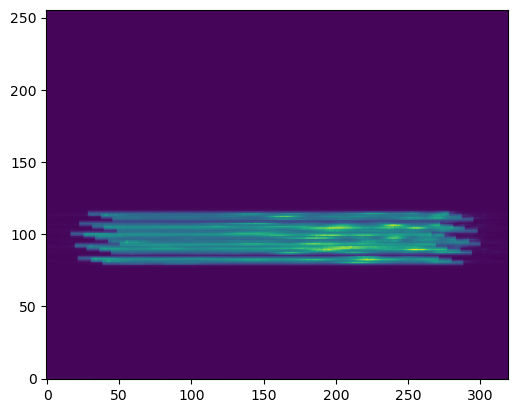

In [112]:
canvas_array = np.zeros(np.shape(test_array))

x_offset = 17-181
y_offset = -1

dict_profiles = {}

# loop over each spectrum's starting position
#for coord_xy in rel_pos.values():
for key, coord_xy in rel_pos.items():

    profile_this_array = simple_profile(array_shape=np.shape(test_array), 
                                x_left=np.add(coord_xy[0],x_offset), 
                                y_left=np.add(coord_xy[1],y_offset), 
                                len_spec=250, 
                                sigma_pass=1)
    
    canvas_array += profile_this_array
    
    # save single profiles in an array
    dict_profiles[key] = profile_this_array

# check overlap is good

plt.imshow(np.add((1e4)*canvas_array,bb_array), origin='lower')
plt.savefig('junk_overlap.png')
#plt.show()

In [90]:
# 19 spectra

# define test data
D = bb_array

# extent of detector in x-dir
x_extent = np.shape(test_array)[1]
y_extent = np.shape(test_array)[0]

# initialize dict to hold flux for each spectrum
eta = {'1':np.zeros(x_extent),
       '2':np.zeros(x_extent),
       '3':np.zeros(x_extent),
       '4':np.zeros(x_extent),
       '5':np.zeros(x_extent),
       '6':np.zeros(x_extent),
       '7':np.zeros(x_extent),
       '8':np.zeros(x_extent),
       '9':np.zeros(x_extent),
       '10':np.zeros(x_extent),
       '11':np.zeros(x_extent),
       '12':np.zeros(x_extent),
       '13':np.zeros(x_extent),
       '14':np.zeros(x_extent),
       '15':np.zeros(x_extent),
       '16':np.zeros(x_extent),
       '17':np.zeros(x_extent),
       '18':np.zeros(x_extent),
       '19':np.zeros(x_extent)}

# loop over cols
for col in range(0,x_extent): 
    
    print(col)
    
    # initialize; just try simple tridiagonal terms for now
    c_01_01 = 0
    c_01_02 = 0
    
    c_02_02 = 0
    c_02_03 = 0
    
    c_03_03 = 0
    c_03_04 = 0
    
    c_04_04 = 0
    c_04_05 = 0
    
    c_05_05 = 0
    c_05_06 = 0
    
    c_06_06 = 0
    c_06_07 = 0
    
    c_07_07 = 0
    c_07_08 = 0
    
    c_08_08 = 0
    c_08_09 = 0
    
    c_09_09 = 0
    c_09_10 = 0
    
    c_10_10 = 0
    c_10_11 = 0
    
    c_11_11 = 0
    c_11_12 = 0
    
    c_12_12 = 0
    c_12_13 = 0
    
    c_13_13 = 0
    c_13_14 = 0
    
    c_14_14 = 0
    c_14_15 = 0
    
    c_15_15 = 0
    c_15_16 = 0
    
    c_16_16 = 0
    c_16_17 = 0
    
    c_17_17 = 0
    c_17_18 = 0
    
    c_18_18 = 0
    c_18_19 = 0
    
    c_19_19 = 0

    b_01 = 0
    b_02 = 0
    b_03 = 0
    b_04 = 0
    b_05 = 0
    b_06 = 0
    b_07 = 0
    b_08 = 0
    b_09 = 0
    b_10 = 0
    b_11 = 0
    b_12 = 0
    b_13 = 0
    b_14 = 0
    b_15 = 0
    b_16 = 0
    b_17 = 0
    b_18 = 0
    b_19 = 0
    
    # loop over pixels in col
    for i in range(0,y_extent):
    
        c_01_01 += dict_profiles['1'][i,col] * dict_profiles['1'][i,col] / array_variance[i,col]
        
        c_01_02 += dict_profiles['1'][i,col] * dict_profiles['2'][i,col] / array_variance[i,col]
        
        #c_01_03 += dict_profiles['1'][i,col] * dict_profiles['3'][i,col] / array_variance[i,col]
        #
        
        c_02_02 += dict_profiles['2'][i,col] * dict_profiles['2'][i,col] / array_variance[i,col]
        
        c_02_03 += dict_profiles['2'][i,col] * dict_profiles['3'][i,col] / array_variance[i,col]
        #
        
        c_03_03 += dict_profiles['3'][i,col] * dict_profiles['3'][i,col] / array_variance[i,col]
        
        c_03_04 += dict_profiles['3'][i,col] * dict_profiles['4'][i,col] / array_variance[i,col]
        #
        
        c_04_04 += dict_profiles['4'][i,col] * dict_profiles['4'][i,col] / array_variance[i,col]
        
        c_04_05 += dict_profiles['4'][i,col] * dict_profiles['5'][i,col] / array_variance[i,col]
        #   
        
        c_05_05 += dict_profiles['5'][i,col] * dict_profiles['5'][i,col] / array_variance[i,col]
        
        c_05_06 += dict_profiles['5'][i,col] * dict_profiles['6'][i,col] / array_variance[i,col]
        #
        
        c_06_06 += dict_profiles['6'][i,col] * dict_profiles['6'][i,col] / array_variance[i,col]
        
        c_06_07 += dict_profiles['6'][i,col] * dict_profiles['7'][i,col] / array_variance[i,col]
        #
        
        c_07_07 += dict_profiles['7'][i,col] * dict_profiles['7'][i,col] / array_variance[i,col]
        
        c_07_08 += dict_profiles['7'][i,col] * dict_profiles['8'][i,col] / array_variance[i,col]
        #
        
        c_08_08 += dict_profiles['8'][i,col] * dict_profiles['8'][i,col] / array_variance[i,col]
        
        c_08_09 += dict_profiles['8'][i,col] * dict_profiles['9'][i,col] / array_variance[i,col]
        #
        
        c_09_09 += dict_profiles['9'][i,col] * dict_profiles['9'][i,col] / array_variance[i,col]
        
        c_09_10 += dict_profiles['9'][i,col] * dict_profiles['10'][i,col] / array_variance[i,col]
        #
        
        c_10_10 += dict_profiles['10'][i,col] * dict_profiles['10'][i,col] / array_variance[i,col]
        
        c_10_11 += dict_profiles['10'][i,col] * dict_profiles['11'][i,col] / array_variance[i,col]
        #
        
        c_11_11 += dict_profiles['11'][i,col] * dict_profiles['11'][i,col] / array_variance[i,col]
        
        c_11_12 += dict_profiles['11'][i,col] * dict_profiles['12'][i,col] / array_variance[i,col]
        #
        
        c_12_12 += dict_profiles['12'][i,col] * dict_profiles['12'][i,col] / array_variance[i,col]
        
        c_12_13 += dict_profiles['12'][i,col] * dict_profiles['13'][i,col] / array_variance[i,col]
        #
        
        c_13_13 += dict_profiles['13'][i,col] * dict_profiles['13'][i,col] / array_variance[i,col]
        
        c_13_14 += dict_profiles['13'][i,col] * dict_profiles['14'][i,col] / array_variance[i,col]
        #
        
        c_14_14 += dict_profiles['14'][i,col] * dict_profiles['14'][i,col] / array_variance[i,col]
        
        c_14_15 += dict_profiles['14'][i,col] * dict_profiles['15'][i,col] / array_variance[i,col]
        #
        
        c_15_15 += dict_profiles['15'][i,col] * dict_profiles['15'][i,col] / array_variance[i,col]
        
        c_15_16 += dict_profiles['15'][i,col] * dict_profiles['16'][i,col] / array_variance[i,col]
        #
        
        c_16_16 += dict_profiles['16'][i,col] * dict_profiles['16'][i,col] / array_variance[i,col]
        
        c_16_17 += dict_profiles['16'][i,col] * dict_profiles['17'][i,col] / array_variance[i,col]
        #
        
        c_17_17 += dict_profiles['17'][i,col] * dict_profiles['17'][i,col] / array_variance[i,col]
        
        c_17_18 += dict_profiles['17'][i,col] * dict_profiles['18'][i,col] / array_variance[i,col]
        #
        
        c_18_18 += dict_profiles['18'][i,col] * dict_profiles['18'][i,col] / array_variance[i,col]
        
        c_18_19 += dict_profiles['18'][i,col] * dict_profiles['19'][i,col] / array_variance[i,col]
        #
        
        c_19_19 += dict_profiles['19'][i,col] * dict_profiles['19'][i,col] / array_variance[i,col]
        #
        
        b_01 += D[i,col] * dict_profiles['1'][i,col] / array_variance[i,col]
        
        b_02 += D[i,col] * dict_profiles['2'][i,col] / array_variance[i,col]
        
        b_03 += D[i,col] * dict_profiles['3'][i,col] / array_variance[i,col]
        
        b_04 += D[i,col] * dict_profiles['4'][i,col] / array_variance[i,col]
        
        b_05 += D[i,col] * dict_profiles['5'][i,col] / array_variance[i,col]
        
        b_06 += D[i,col] * dict_profiles['6'][i,col] / array_variance[i,col]
        
        b_07 += D[i,col] * dict_profiles['7'][i,col] / array_variance[i,col]
        
        b_08 += D[i,col] * dict_profiles['8'][i,col] / array_variance[i,col]
        
        b_09 += D[i,col] * dict_profiles['9'][i,col] / array_variance[i,col]
        
        b_10 += D[i,col] * dict_profiles['10'][i,col] / array_variance[i,col]
        
        b_11 += D[i,col] * dict_profiles['11'][i,col] / array_variance[i,col]
        
        b_12 += D[i,col] * dict_profiles['12'][i,col] / array_variance[i,col]
        
        b_13 += D[i,col] * dict_profiles['13'][i,col] / array_variance[i,col]
        
        b_14 += D[i,col] * dict_profiles['14'][i,col] / array_variance[i,col]
        
        b_15 += D[i,col] * dict_profiles['15'][i,col] / array_variance[i,col]
        
        b_16 += D[i,col] * dict_profiles['16'][i,col] / array_variance[i,col]
        
        b_17 += D[i,col] * dict_profiles['17'][i,col] / array_variance[i,col]
        
        b_18 += D[i,col] * dict_profiles['18'][i,col] / array_variance[i,col]
        
        b_19 += D[i,col] * dict_profiles['19'][i,col] / array_variance[i,col]
        
    # by symmetry
    c_02_01 = np.copy(c_01_02)
    c_03_02 = np.copy(c_02_03)
    c_04_03 = np.copy(c_03_04)
    c_05_04 = np.copy(c_04_05)
    c_06_05 = np.copy(c_05_06)
    c_07_06 = np.copy(c_06_07)
    c_08_07 = np.copy(c_07_08)
    c_09_08 = np.copy(c_08_09)
    c_10_09 = np.copy(c_09_10)
    c_11_10 = np.copy(c_10_11)
    c_12_11 = np.copy(c_11_12)
    c_13_12 = np.copy(c_12_13)
    c_14_13 = np.copy(c_13_14)
    c_15_14 = np.copy(c_14_15)
    c_16_15 = np.copy(c_15_16)
    c_17_16 = np.copy(c_16_17)
    c_18_17 = np.copy(c_17_18)
    c_19_18 = np.copy(c_18_19)
    
    #print(c_21)
    #print(c_31)
    
    #plt.clf()
    #c_mat_display = np.array([[c_11, c_12, c_13],[c_21, c_22, c_23],[c_31, c_32, c_33]])
    #plt.imshow(c_mat_display, origin='lower')
    #plt.show()
    
    # set off-diagonal vals to zero to make sparse
    '''
    c_21 = 0
    c_12 = 0
    c_13 = 0
    c_31 = 0
    c_23 = 0
    c_32 = 0
    '''
    
    # assemble matrices
    b_mat = np.array([b_01, b_02, b_03, b_04, b_05, b_06, b_07, b_08, b_09, b_10, b_11, b_12, b_13, b_14, b_15, b_16, b_17, b_18, b_19])
    c_mat = np.zeros((19,19))
    # populate
    
    c_mat[0,0] = c_01_01
    c_mat[1,1] = c_02_02
    c_mat[2,2] = c_03_03
    c_mat[3,3] = c_04_04
    c_mat[4,4] = c_05_05
    c_mat[5,5] = c_06_06
    c_mat[6,6] = c_07_07
    c_mat[7,7] = c_08_08
    c_mat[8,8] = c_09_09
    c_mat[9,9] = c_10_10
    c_mat[10,10] = c_11_11
    c_mat[11,11] = c_12_12
    c_mat[12,12] = c_13_13
    c_mat[13,13] = c_14_14
    c_mat[14,14] = c_15_15
    c_mat[15,15] = c_16_16
    c_mat[16,16] = c_17_17
    c_mat[17,17] = c_18_18
    c_mat[18,18] = c_19_19
    
    c_mat[0,1] = c_01_02
    c_mat[1,2] = c_02_03
    c_mat[2,3] = c_03_04
    c_mat[3,4] = c_04_05
    c_mat[4,5] = c_05_06
    c_mat[5,6] = c_06_07
    c_mat[6,7] = c_07_08
    c_mat[7,8] = c_08_09
    c_mat[8,9] = c_09_10
    c_mat[9,10] = c_10_11
    c_mat[10,11] = c_11_12
    c_mat[11,12] = c_12_13
    c_mat[12,13] = c_13_14
    c_mat[13,14] = c_14_15
    c_mat[14,15] = c_15_16
    c_mat[15,16] = c_16_17
    c_mat[16,17] = c_17_18
    c_mat[17,18] = c_18_19
    
    c_mat[1,0] = c_02_01
    c_mat[2,1] = c_03_02
    c_mat[3,2] = c_04_03
    c_mat[4,3] = c_05_04
    c_mat[5,4] = c_06_05
    c_mat[6,5] = c_07_06
    c_mat[7,6] = c_08_07
    c_mat[8,7] = c_09_08
    c_mat[8,9] = c_10_09
    c_mat[10,9] = c_11_10
    c_mat[11,10] = c_12_11
    c_mat[12,11] = c_13_12
    c_mat[13,12] = c_14_13
    c_mat[14,13] = c_15_14
    c_mat[15,14] = c_16_15
    c_mat[16,15] = c_17_16
    c_mat[17,16] = c_18_17
    c_mat[18,17] = c_19_18
    
    #import ipdb; ipdb.set_trace()
    
    #plt.imshow(c_mat)
    #plt.show()

    
    # solve for the following transform:
    # x * c_mat = b_mat  -->  c_mat.T * x.T = b_mat.T
    eta_mat_T, istop, itn, normr, normar, norma, conda, normx = \
               lsmr(c_mat.transpose(), b_mat.transpose())
    
    eta_mat =  eta_mat_T.transpose()
    
    eta['1'][col] = eta_mat[0]
    eta['2'][col] = eta_mat[1]
    eta['3'][col] = eta_mat[2]
    eta['4'][col] = eta_mat[3]
    eta['5'][col] = eta_mat[4]
    eta['6'][col] = eta_mat[5]
    eta['7'][col] = eta_mat[6]
    eta['8'][col] = eta_mat[7]
    eta['9'][col] = eta_mat[8]
    eta['10'][col] = eta_mat[9]
    eta['11'][col] = eta_mat[10]
    eta['12'][col] = eta_mat[11]
    eta['13'][col] = eta_mat[12]
    eta['14'][col] = eta_mat[13]
    eta['15'][col] = eta_mat[14]
    eta['16'][col] = eta_mat[15]
    eta['17'][col] = eta_mat[16]
    eta['18'][col] = eta_mat[17]
    eta['19'][col] = eta_mat[18]

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26


/var/folders/8y/ztvmc5ys1pn64bjywt1qp4k40000gs/T/ipykernel_9371/1129894119.py:116: RuntimeWarning: invalid value encountered in double_scalars
  c_01_01 += dict_profiles['1'][i,col] * dict_profiles['1'][i,col] / array_variance[i,col]
/var/folders/8y/ztvmc5ys1pn64bjywt1qp4k40000gs/T/ipykernel_9371/1129894119.py:118: RuntimeWarning: invalid value encountered in double_scalars
  c_01_02 += dict_profiles['1'][i,col] * dict_profiles['2'][i,col] / array_variance[i,col]
/var/folders/8y/ztvmc5ys1pn64bjywt1qp4k40000gs/T/ipykernel_9371/1129894119.py:123: RuntimeWarning: invalid value encountered in double_scalars
  c_02_02 += dict_profiles['2'][i,col] * dict_profiles['2'][i,col] / array_variance[i,col]
/var/folders/8y/ztvmc5ys1pn64bjywt1qp4k40000gs/T/ipykernel_9371/1129894119.py:125: RuntimeWarning: invalid value encountered in double_scalars
  c_02_03 += dict_profiles['2'][i,col] * dict_profiles['3'][i,col] / array_variance[i,col]
/var/folders/8y/ztvmc5ys1pn64bjywt1qp4k40000gs/T/ipykernel_9371/

27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
2

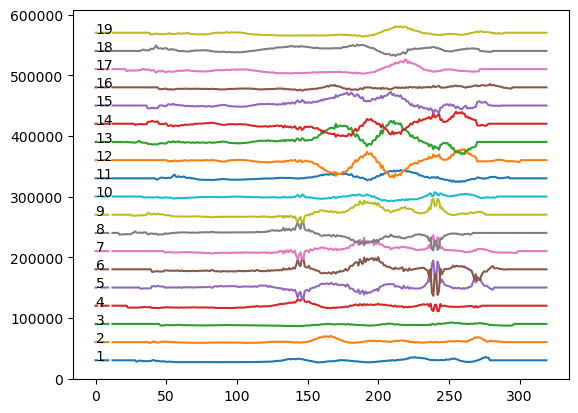

In [113]:
for i in range(1,len(eta)+1):
    
    plt.plot(np.add(eta[str(i)],30000*i))
    plt.annotate(str(i), (0,30000*i), xytext=None)

plt.savefig('junk_19specs.png')
#plt.show()